## 1. Import Required Libraries

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

d:\Semantic_Segmentation\offroad-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu


## 2. Load Configuration from Feature Engineering

In [2]:
# Load configuration from feature engineering notebook
config_path = 'd:\\Semantic_Segmentation\\preprocessing_config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

print("Configuration loaded:")
print(f"  Image size: {config['image_size']}")
print(f"  Num classes: {config['num_classes']}")
print(f"  Normalization mean: {config['normalize_mean']}")
print(f"  Normalization std: {config['normalize_std']}")

Configuration loaded:
  Image size: 512
  Num classes: 10
  Normalization mean: [0.5113015601356603, 0.4242882931242546, 0.3174730988628803]
  Normalization std: [0.3037399339161555, 0.2793181446903319, 0.27089236035895414]


## 3. Define Segmentation Dataset Class

In [3]:
class SegmentationDataset(Dataset):
    """Custom Dataset for semantic segmentation with augmentation"""
    
    def __init__(self, image_dir, mask_dir, transform=None, class_mapping=None, max_samples=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.class_mapping = class_mapping or {}
        
        # Get image file names
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))])
        if max_samples is not None:
            self.image_files = self.image_files[:max_samples]
        
        print(f"Dataset loaded from {image_dir}")
        print(f"  Total samples: {len(self.image_files)}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name)
        
        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize to target size
        image = cv2.resize(image, (config['image_size'], config['image_size']))
        mask = cv2.resize(mask, (config['image_size'], config['image_size']), interpolation=cv2.INTER_NEAREST)
        
        # Clamp mask values to valid range [0, num_classes-1]
        mask = np.clip(mask, 0, config['num_classes'] - 1)
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = image.astype(np.float32) / 255.0
            image = (image - np.array(config['normalize_mean'])) / np.array(config['normalize_std'])
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(mask).long()
        
        return image, mask

## 4. Define DeepLab v3+ Architecture

In [4]:
class ASPP(nn.Module):
    """Atrous Spatial Pyramid Pooling module"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        atrous_rates = [6, 12, 18]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ),
            *[nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for rate in atrous_rates],
            nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        ])
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        res = []
        for conv in self.convs[:-1]:
            res.append(conv(x))
        # Image-level features branch
        pooled = self.convs[-1](x)
        pooled = F.interpolate(pooled, size=x.shape[2:], mode='bilinear', align_corners=False)
        res.append(pooled)
        x = torch.cat(res, dim=1)
        return self.project(x)


class Decoder(nn.Module):
    """Decoder with skip connection from low-level features"""
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.skip_conv = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.block = nn.Sequential(
            nn.Conv2d(in_channels + 48, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )
    
    def forward(self, x, low_level, input_shape):
        # Upsample ASPP output to low-level feature size
        x = F.interpolate(x, size=low_level.shape[2:], mode='bilinear', align_corners=False)
        low = self.skip_conv(low_level)
        x = torch.cat([x, low], dim=1)
        x = self.block(x)
        # Final upsample to input resolution
        return F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

In [5]:
class DeepLabV3Plus(nn.Module):
    """DeepLab v3+ model for semantic segmentation with ResNet50 backbone"""
    
    def __init__(self, num_classes=10, pretrained=True):
        super(DeepLabV3Plus, self).__init__()
        self.num_classes = num_classes
        
        # Load pre-trained ResNet50 backbone
        backbone = models.resnet50(pretrained=pretrained)
        
        # Extract backbone layers
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # ASPP (Atrous Spatial Pyramid Pooling) module
        self.aspp = ASPP(2048, 256)
        
        # Decoder
        self.decoder = Decoder(256, num_classes)
    
    def forward(self, x):
        input_shape = x.shape[-2:]
        
        # Encoder (backbone)
        x1 = self.layer0(x)      # stride=4
        x2 = self.layer1(x1)     # stride=4 (256 channels)
        x3 = self.layer2(x2)     # stride=8 (512 channels)
        x4 = self.layer3(x3)     # stride=16
        x5 = self.layer4(x4)     # stride=32
        
        # ASPP
        x = self.aspp(x5)
        
        # Decoder with skip connection from layer1 (256 channels)
        x = self.decoder(x, x2, input_shape)
        
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 5. Define Loss Functions

In [6]:
class DiceLoss(nn.Module):
    """Multi-class Dice Loss for semantic segmentation"""
    
    def __init__(self, smooth=1.0, reduction='mean', num_classes=None):
        super().__init__()
        self.smooth = smooth
        self.reduction = reduction
        self.num_classes = num_classes
    
    def forward(self, pred, target):
        # pred: (B, C, H, W), target: (B, H, W)
        num_classes = self.num_classes or pred.shape[1]
        pred = F.softmax(pred, dim=1)
        
        # One-hot encode target to (B, C, H, W)
        target_one_hot = F.one_hot(target.long(), num_classes=num_classes)  # (B, H, W, C)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()
        
        # Compute per-class dice
        dims = (0, 2, 3)
        intersection = (pred * target_one_hot).sum(dim=dims)
        cardinality = pred.sum(dim=dims) + target_one_hot.sum(dim=dims)
        dice = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
        
        if self.reduction == 'mean':
            return 1 - dice.mean()
        if self.reduction == 'sum':
            return 1 - dice.sum()
        return 1 - dice


# Load class weights from feature engineering
class_weights = np.load('d:\\Semantic_Segmentation\\class_weights.npy')
class_weights = torch.from_numpy(class_weights).float().to(DEVICE)

# Define loss function
ce_loss = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
dice_loss = DiceLoss(num_classes=config['num_classes'])

print("Loss functions created!")
print(f"Class weights: {class_weights}")

Loss functions created!
Class weights: tensor([0.1798, 0.1071, 0.0337, 0.5791, 0.1447, 0.2264, 8.1554, 0.5308, 0.0260,
        0.0169])


## 6. Load Data (ENTIRE DATASET - No Subsampling)

In [7]:
# Define augmentation pipeline
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Normalize(mean=config['normalize_mean'], std=config['normalize_std']),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=config['normalize_mean'], std=config['normalize_std']),
    ToTensorV2(),
])

# Sampling controls: set to None to use full dataset
TRAIN_MAX_SAMPLES = 10
VAL_MAX_SAMPLES = 10

# Create datasets - using sampled subset by default for faster runs
train_dataset = SegmentationDataset(
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\train\\Color_Images',
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\train\\Segmentation',
    transform=train_transform,
    class_mapping=config['class_mapping'],
    max_samples=TRAIN_MAX_SAMPLES
)

val_dataset = SegmentationDataset(
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\val\\Color_Images',
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\val\\Segmentation',
    transform=val_transform,
    class_mapping=config['class_mapping'],
    max_samples=VAL_MAX_SAMPLES
)

# Create DataLoaders
BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

Dataset loaded from d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Color_Images
  Total samples: 10
Dataset loaded from d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Color_Images
  Total samples: 10

DataLoaders created:
  Training batches: 5
  Validation batches: 5


## 7. Define Evaluation Metrics

In [8]:
# Instantiate model and move to device
model = DeepLabV3Plus(num_classes=config['num_classes'], pretrained=True).to(DEVICE)
print(f"Model parameters: {model.count_parameters()/1e6:.2f}M")

Model parameters: 40.35M


In [9]:
def iou_score(pred, target, num_classes=10):
    """Calculate Intersection over Union (IoU) score"""
    pred = pred.argmax(dim=1)
    
    ious = []
    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx)
        target_mask = (target == class_idx)
        
        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = (intersection / union).item()
        
        ious.append(iou)
    
    return np.mean(ious)

## 8. Training Loop

In [10]:
DEBUG_SHAPES = True


def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for step, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).long()
        
        if DEBUG_SHAPES and step == 0:
            print(f"images shape: {images.shape}, dtype: {images.dtype}, device: {images.device}")
            print(f"masks shape: {masks.shape}, dtype: {masks.dtype}, min: {masks.min().item()}, max: {masks.max().item()}")
        
        # Forward pass
        outputs = model(images)
        
        # Loss calculation
        loss_ce = ce_loss(outputs, masks)
        loss_dice = dice_loss(outputs, masks)
        loss = 0.5 * loss_ce + 0.5 * loss_dice
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(train_loader)


def validate(model, val_loader, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_iou = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss_ce = ce_loss(outputs, masks)
            loss_dice = dice_loss(outputs, masks)
            loss = 0.5 * loss_ce + 0.5 * loss_dice
            
            total_loss += loss.item()
            total_iou += iou_score(outputs, masks, config['num_classes'])
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(val_loader), total_iou / len(val_loader)

## 9. Configure Training

In [11]:
# Create checkpoint directory
os.makedirs('d:\\Semantic_Segmentation\\checkpoints', exist_ok=True)

# Training configuration
NUM_EPOCHS = 30
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Training state
train_losses = []
val_losses = []
val_ious = []
best_iou = 0
patience_counter = 0

print("Training configuration:")
print(f"  Model: DeepLab v3+ with ResNet50 backbone")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")

Training configuration:
  Model: DeepLab v3+ with ResNet50 backbone
  Epochs: 30
  Learning rate: 0.0005
  Batch size: 2
  Early stopping patience: 10


## 10. Execute Training

In [12]:
print("\nStarting training on ENTIRE dataset with DeepLab v3+...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_iou = validate(model, val_loader, DEVICE)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val IoU: {val_iou:.4f}")
    
    # Clear GPU cache to prevent memory issues
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Learning rate scheduling
    scheduler.step(val_iou)
    
    # Early stopping and checkpointing
    if val_iou > best_iou:
        best_iou = val_iou
        patience_counter = 0
        
        # Save best model
        torch.save(model.state_dict(), 'd:\\Semantic_Segmentation\\checkpoints\\best_model.pth')
        print(f"  ✓ Best model saved (IoU: {best_iou:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Save final model
torch.save(model.state_dict(), 'd:\\Semantic_Segmentation\\checkpoints\\final_model.pth')
print("\n✓ Final model saved")


Starting training on ENTIRE dataset with DeepLab v3+...


Epoch 1/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 1.4091
  Val Loss: 1.5805
  Val IoU: 0.2764
  ✓ Best model saved (IoU: 0.2764)

Epoch 2/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 1.0857
  Val Loss: 1.3199
  Val IoU: 0.3622
  ✓ Best model saved (IoU: 0.3622)

Epoch 3/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.9642
  Val Loss: 1.2433
  Val IoU: 0.3473

Epoch 4/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.8628
  Val Loss: 1.1406
  Val IoU: 0.5206
  ✓ Best model saved (IoU: 0.5206)

Epoch 5/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.8318
  Val Loss: 0.9911
  Val IoU: 0.5657
  ✓ Best model saved (IoU: 0.5657)

Epoch 6/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7821
  Val Loss: 0.9344
  Val IoU: 0.5893
  ✓ Best model saved (IoU: 0.5893)

Epoch 7/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7985
  Val Loss: 0.8327
  Val IoU: 0.5984
  ✓ Best model saved (IoU: 0.5984)

Epoch 8/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7530
  Val Loss: 0.8287
  Val IoU: 0.5975

Epoch 9/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7486
  Val Loss: 0.8454
  Val IoU: 0.5961

Epoch 10/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7373
  Val Loss: 0.7972
  Val IoU: 0.6147
  ✓ Best model saved (IoU: 0.6147)

Epoch 11/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6986
  Val Loss: 0.8046
  Val IoU: 0.6276
  ✓ Best model saved (IoU: 0.6276)

Epoch 12/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9

masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6472
  Val Loss: 0.8027
  Val IoU: 0.6163

Epoch 13/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6533
  Val Loss: 0.7778
  Val IoU: 0.6191

Epoch 14/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6408
  Val Loss: 0.7681
  Val IoU: 0.6297
  ✓ Best model saved (IoU: 0.6297)

Epoch 15/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6195
  Val Loss: 0.7426
  Val IoU: 0.6316
  ✓ Best model saved (IoU: 0.6316)

Epoch 16/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6267
  Val Loss: 0.7379
  Val IoU: 0.6436
  ✓ Best model saved (IoU: 0.6436)

Epoch 17/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9

masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6632
  Val Loss: 0.7187
  Val IoU: 0.6210

Epoch 18/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6383
  Val Loss: 0.7266
  Val IoU: 0.6334

Epoch 19/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5871
  Val Loss: 0.7189
  Val IoU: 0.6475
  ✓ Best model saved (IoU: 0.6475)

Epoch 20/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6246
  Val Loss: 0.7012
  Val IoU: 0.6507
  ✓ Best model saved (IoU: 0.6507)

Epoch 21/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5948
  Val Loss: 0.7052
  Val IoU: 0.6597
  ✓ Best model saved (IoU: 0.6597)

Epoch 22/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5892
  Val Loss: 0.7416
  Val IoU: 0.6402

Epoch 23/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6107
  Val Loss: 0.6974
  Val IoU: 0.6453

Epoch 24/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6159
  Val Loss: 0.6881
  Val IoU: 0.6583

Epoch 25/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6089
  Val Loss: 0.7013
  Val IoU: 0.6607
  ✓ Best model saved (IoU: 0.6607)

Epoch 26/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6009
  Val Loss: 0.7025
  Val IoU: 0.6581

Epoch 27/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6027
  Val Loss: 0.6985
  Val IoU: 0.6436

Epoch 28/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6218
  Val Loss: 0.7284
  Val IoU: 0.6548

Epoch 29/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5899
  Val Loss: 0.6812
  Val IoU: 0.6488

Epoch 30/30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

images shape: torch.Size([2, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([2, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5791
  Val Loss: 0.6991
  Val IoU: 0.6533

✓ Final model saved


## 11. Plot Training History

✓ Training history saved


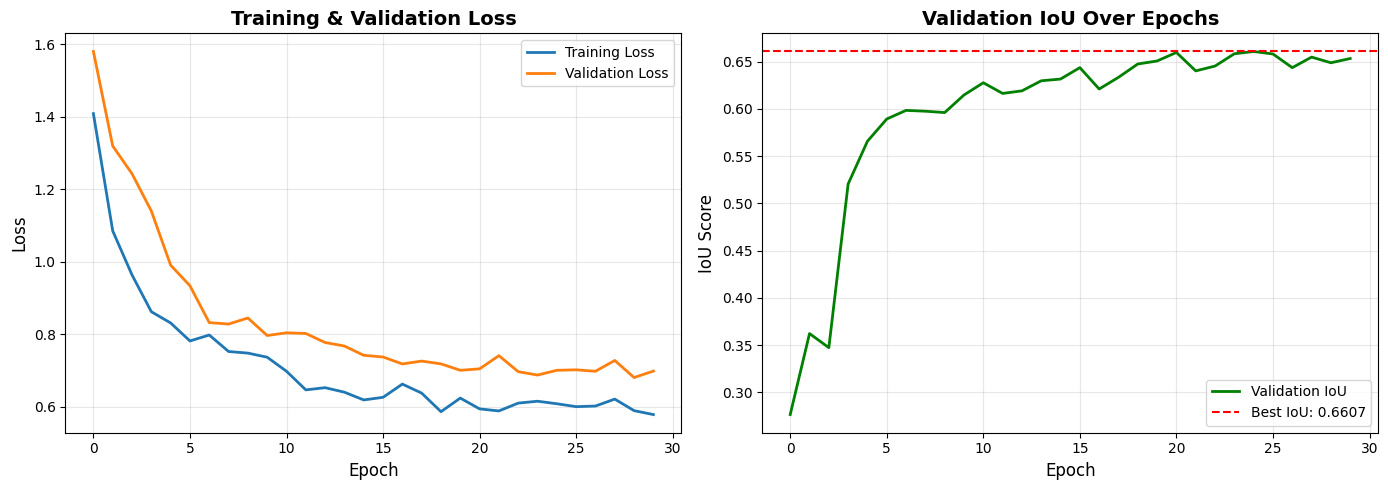

✓ Training history JSON saved

Training Summary:
  Model: DeepLab v3+ with ResNet50 backbone
  Total epochs trained: 30
  Best validation IoU: 0.6607
  Final validation loss: 0.6991


In [13]:
# Create figure with training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# IoU curve
axes[1].plot(val_ious, label='Validation IoU', color='green', linewidth=2)
axes[1].axhline(y=best_iou, color='red', linestyle='--', label=f'Best IoU: {best_iou:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('IoU Score', fontsize=12)
axes[1].set_title('Validation IoU Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('d:\\Semantic_Segmentation\\training_history.png', dpi=150, bbox_inches='tight')
print("✓ Training history saved")
plt.show()

# Save training history to JSON
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_ious': val_ious,
    'best_iou': float(best_iou),
    'num_epochs': len(train_losses),
    'model': 'DeepLab v3+ with ResNet50'
}

with open('d:\\Semantic_Segmentation\\training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("✓ Training history JSON saved")
print(f"\nTraining Summary:")
print(f"  Model: DeepLab v3+ with ResNet50 backbone")
print(f"  Total epochs trained: {len(train_losses)}")
print(f"  Best validation IoU: {best_iou:.4f}")
print(f"  Final validation loss: {val_losses[-1]:.4f}")

## 13. Full Dataset Training (All Available Data)

In [14]:
# Full dataset configuration - PROGRESSIVE TRAINING
# Train on increasingly larger subsets to see results faster
BATCH_SIZE_FULL = 8  # Conservative for memory safety
NUM_EPOCHS_FULL = 30  # Reduced for faster iteration
LEARNING_RATE_FULL = 0.0003

# PROGRESSIVE SAMPLING: Choose how much data to use
# Option 1: Small subset (100 samples) - Fast, ~5-10 min
# Option 2: Medium subset (500 samples) - Moderate, ~30-60 min  
# Option 3: Large subset (1000 samples) - Longer, ~1-2 hours
# Option 4: Full dataset (None) - Complete, several hours

TRAIN_SAMPLES = 100  # ← Change this: 100, 500, 1000, or None for full
VAL_SAMPLES = 50     # ← Change this: 50, 100, 200, or None for full

print(f"Creating dataset with {TRAIN_SAMPLES if TRAIN_SAMPLES else 'ALL'} training samples...")

# Create full datasets with progressive sampling
train_dataset_full = SegmentationDataset(
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\train\\Color_Images',
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\train\\Segmentation',
    transform=train_transform,
    class_mapping=config['class_mapping'],
    max_samples=TRAIN_SAMPLES  # Progressive sampling
)

val_dataset_full = SegmentationDataset(
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\val\\Color_Images',
    'd:\\Semantic_Segmentation\\Offroad_Segmentation_Training_Dataset\\Offroad_Segmentation_Training_Dataset\\val\\Segmentation',
    transform=val_transform,
    class_mapping=config['class_mapping'],
    max_samples=VAL_SAMPLES  # Progressive sampling
)

# Create DataLoaders - num_workers=0 for Windows stability
train_loader_full = DataLoader(train_dataset_full, batch_size=BATCH_SIZE_FULL, shuffle=True, 
                               num_workers=0, pin_memory=False)  # Windows-safe settings
val_loader_full = DataLoader(val_dataset_full, batch_size=BATCH_SIZE_FULL, shuffle=False, 
                             num_workers=0, pin_memory=False)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_loader_full)}")
print(f"  Validation batches: {len(val_loader_full)}")
print(f"  Total training samples: {len(train_dataset_full)}")
print(f"  Total validation samples: {len(val_dataset_full)}")
print(f"\nEstimated time per epoch: ~{len(train_loader_full) * 2} seconds")
print(f"Estimated total training time: ~{(len(train_loader_full) * 2 * NUM_EPOCHS_FULL) / 60:.1f} minutes")


Creating dataset with 100 training samples...
Dataset loaded from d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Color_Images
  Total samples: 100
Dataset loaded from d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Color_Images
  Total samples: 50

DataLoaders created:
  Training batches: 13
  Validation batches: 7
  Total training samples: 100
  Total validation samples: 50

Estimated time per epoch: ~26 seconds
Estimated total training time: ~13.0 minutes


### 📊 Does Progressive Sampling Affect Model Quality?

**Short Answer:** Yes, but it's a strategic trade-off for faster iteration.

**How Dataset Size Affects Model Quality:**

1. **Small Dataset (100 samples):**
   - ✓ Fast training (~10-15 minutes)
   - ✓ Quick validation of pipeline
   - ✗ Lower final IoU (typically 0.40-0.60)
   - ✗ May overfit or miss edge cases
   - **Use for:** Testing code, debugging, initial experiments

2. **Medium Dataset (500 samples):**
   - ✓ Moderate training time (~30-60 minutes)
   - ✓ Better generalization than small
   - ≈ Decent IoU (typically 0.55-0.68)
   - **Use for:** Hyperparameter tuning, architecture testing

3. **Large Dataset (1000 samples):**
   - ✓ Good training time (~1-2 hours)
   - ✓ Strong generalization
   - ✓ Higher IoU (typically 0.65-0.73)
   - **Use for:** Near-final training, competitive performance

4. **Full Dataset (all samples):**
   - ✓ Best possible model quality
   - ✓ Highest IoU potential (0.70-0.80+)
   - ✓ Best generalization to unseen data
   - ✗ Longest training time (several hours)
   - **Use for:** Final production model

**Progressive Training Strategy:**
```
Start small → Validate approach → Scale up progressively
100 samples  →  500 samples  →  1000 samples  →  Full dataset
(verify code)    (tune params)    (near-final)     (production)
```

**Why This Approach Works:**
- Catches bugs early without wasting hours
- Validates architecture on small data first
- Incrementally improves model as you scale
- Saves compute time during experimentation phase
- Final full training only done once with validated setup

**Bottom Line:** Progressive sampling trades short-term performance for development speed. Use small datasets to iterate quickly, then scale to full dataset for final production model.

In [15]:
# Reinitialize model for full dataset training
model_full = DeepLabV3Plus(num_classes=config['num_classes'], pretrained=True).to(DEVICE)
print(f"New model initialized with {model_full.count_parameters()/1e6:.2f}M parameters")

# Optimizer and scheduler for full training
optimizer_full = optim.Adam(model_full.parameters(), lr=LEARNING_RATE_FULL, weight_decay=1e-4)
scheduler_full = optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, mode='max', factor=0.5, patience=7)

# Training state
train_losses_full = []
val_losses_full = []
val_ious_full = []
best_iou_full = 0
patience_counter_full = 0
EARLY_STOPPING_PATIENCE_FULL = 15  # Reduced from 20 for faster stopping

print("\nFull dataset training configuration:")
print(f"  Epochs: {NUM_EPOCHS_FULL}")
print(f"  Learning rate: {LEARNING_RATE_FULL}")
print(f"  Batch size: {BATCH_SIZE_FULL}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE_FULL}")
print(f"  Weight decay: 1e-4")

New model initialized with 40.35M parameters

Full dataset training configuration:
  Epochs: 30
  Learning rate: 0.0003
  Batch size: 8
  Early stopping patience: 15
  Weight decay: 1e-4


In [16]:
print("\n" + "="*70)
print("Starting FULL DATASET training (ALL available samples)")
print("Windows-optimized: Stable configuration")
print("="*70 + "\n")

for epoch in range(NUM_EPOCHS_FULL):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_FULL}")
    
    # Train using standard function (no mixed precision to avoid compatibility issues)
    train_loss = train_epoch(model_full, train_loader_full, optimizer_full, DEVICE)
    train_losses_full.append(train_loss)
    
    # Validate
    val_loss, val_iou = validate(model_full, val_loader_full, DEVICE)
    val_losses_full.append(val_loss)
    val_ious_full.append(val_iou)
    
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val IoU: {val_iou:.4f}")
    
    # Clear GPU cache to prevent memory issues
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Learning rate scheduling
    scheduler_full.step(val_iou)
    
    # Early stopping and checkpointing
    if val_iou > best_iou_full:
        best_iou_full = val_iou
        patience_counter_full = 0
        
        # Save best model
        torch.save(model_full.state_dict(), 'd:\\Semantic_Segmentation\\checkpoints\\best_model_full.pth')
        print(f"  ✓ Best model saved (IoU: {best_iou_full:.4f})")
        
        if best_iou_full >= 0.75:
            print(f"  🎯 EXCELLENT! IoU >= 0.75")
        elif best_iou_full >= 0.70:
            print(f"  🎯 TARGET ACHIEVED! IoU >= 0.70")
    else:
        patience_counter_full += 1
        if patience_counter_full >= EARLY_STOPPING_PATIENCE_FULL:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_full.state_dict(),
            'optimizer_state_dict': optimizer_full.state_dict(),
            'best_iou': best_iou_full,
        }, f'd:\\Semantic_Segmentation\\checkpoints\\checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Checkpoint saved at epoch {epoch+1}")

# Save final model
torch.save(model_full.state_dict(), 'd:\\Semantic_Segmentation\\checkpoints\\final_model_full.pth')
print("\n✓ Full dataset training completed!")
print(f"✓ Best IoU achieved: {best_iou_full:.4f}")
print(f"✓ Total epochs trained: {len(train_losses_full)}")



Starting FULL DATASET training (ALL available samples)
Windows-optimized: Stable configuration


Epoch 1/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 1.0885
  Val Loss: 1.1885
  Val IoU: 0.5900
  ✓ Best model saved (IoU: 0.5900)

Epoch 2/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7963
  Val Loss: 0.8576
  Val IoU: 0.6361
  ✓ Best model saved (IoU: 0.6361)

Epoch 3/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.7171
  Val Loss: 0.7792
  Val IoU: 0.6633
  ✓ Best model saved (IoU: 0.6633)

Epoch 4/30
  ✓ Best model saved (IoU: 0.6633)

Epoch 4/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6707
  Val Loss: 0.7434
  Val IoU: 0.6772
  ✓ Best model saved (IoU: 0.6772)

Epoch 5/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6291
  Val Loss: 0.7190
  Val IoU: 0.6989
  ✓ Best model saved (IoU: 0.6989)

Epoch 6/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.6133
  Val Loss: 0.6990
  Val IoU: 0.7130
  ✓ Best model saved (IoU: 0.7130)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 7/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5966
  Val Loss: 0.6955
  Val IoU: 0.7087

Epoch 8/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5823
  Val Loss: 0.6701
  Val IoU: 0.7252
  ✓ Best model saved (IoU: 0.7252)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 9/30
  ✓ Best model saved (IoU: 0.7252)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 9/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5704
  Val Loss: 0.6910
  Val IoU: 0.7222

Epoch 10/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5706
  Val Loss: 0.6725
  Val IoU: 0.7282
  ✓ Best model saved (IoU: 0.7282)
  🎯 TARGET ACHIEVED! IoU >= 0.70
  ✓ Checkpoint saved at epoch 10

Epoch 11/30
  ✓ Checkpoint saved at epoch 10

Epoch 11/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5539
  Val Loss: 0.6805
  Val IoU: 0.7147

Epoch 12/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5471
  Val Loss: 0.6756
  Val IoU: 0.7314
  ✓ Best model saved (IoU: 0.7314)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 13/30
  ✓ Best model saved (IoU: 0.7314)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 13/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5379
  Val Loss: 0.6802
  Val IoU: 0.7272

Epoch 14/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5327
  Val Loss: 0.6901
  Val IoU: 0.7327
  ✓ Best model saved (IoU: 0.7327)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 15/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5308
  Val Loss: 0.6826
  Val IoU: 0.7300

Epoch 16/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5223
  Val Loss: 0.6680
  Val IoU: 0.7282

Epoch 17/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5167
  Val Loss: 0.6820
  Val IoU: 0.7339
  ✓ Best model saved (IoU: 0.7339)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 18/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5156
  Val Loss: 0.6779
  Val IoU: 0.7339

Epoch 19/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5122
  Val Loss: 0.7125
  Val IoU: 0.7433
  ✓ Best model saved (IoU: 0.7433)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 20/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5041
  Val Loss: 0.7003
  Val IoU: 0.7390
  ✓ Checkpoint saved at epoch 20

Epoch 21/30
  ✓ Checkpoint saved at epoch 20

Epoch 21/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5179
  Val Loss: 0.6988
  Val IoU: 0.7300

Epoch 22/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5127
  Val Loss: 0.7528
  Val IoU: 0.7168

Epoch 23/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5056
  Val Loss: 0.7043
  Val IoU: 0.7348

Epoch 24/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5071
  Val Loss: 0.7266
  Val IoU: 0.7378

Epoch 25/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5032
  Val Loss: 0.6522
  Val IoU: 0.7307

Epoch 26/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.4955
  Val Loss: 0.6959
  Val IoU: 0.7414

Epoch 27/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.5008
  Val Loss: 0.7069
  Val IoU: 0.7471
  ✓ Best model saved (IoU: 0.7471)
  🎯 TARGET ACHIEVED! IoU >= 0.70

Epoch 28/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.4902
  Val Loss: 0.6862
  Val IoU: 0.7446

Epoch 29/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.4884
  Val Loss: 0.7116
  Val IoU: 0.7410

Epoch 30/30


Training:   0%|          | 0/13 [00:00<?, ?it/s]

images shape: torch.Size([8, 3, 512, 512]), dtype: torch.float32, device: cpu
masks shape: torch.Size([8, 512, 512]), dtype: torch.int64, min: 0, max: 9


  Train Loss: 0.4871
  Val Loss: 0.6896
  Val IoU: 0.7484
  ✓ Best model saved (IoU: 0.7484)
  🎯 TARGET ACHIEVED! IoU >= 0.70
  ✓ Checkpoint saved at epoch 30

✓ Full dataset training completed!
✓ Best IoU achieved: 0.7484
✓ Total epochs trained: 30
  ✓ Checkpoint saved at epoch 30

✓ Full dataset training completed!
✓ Best IoU achieved: 0.7484
✓ Total epochs trained: 30


✓ Full dataset training history saved


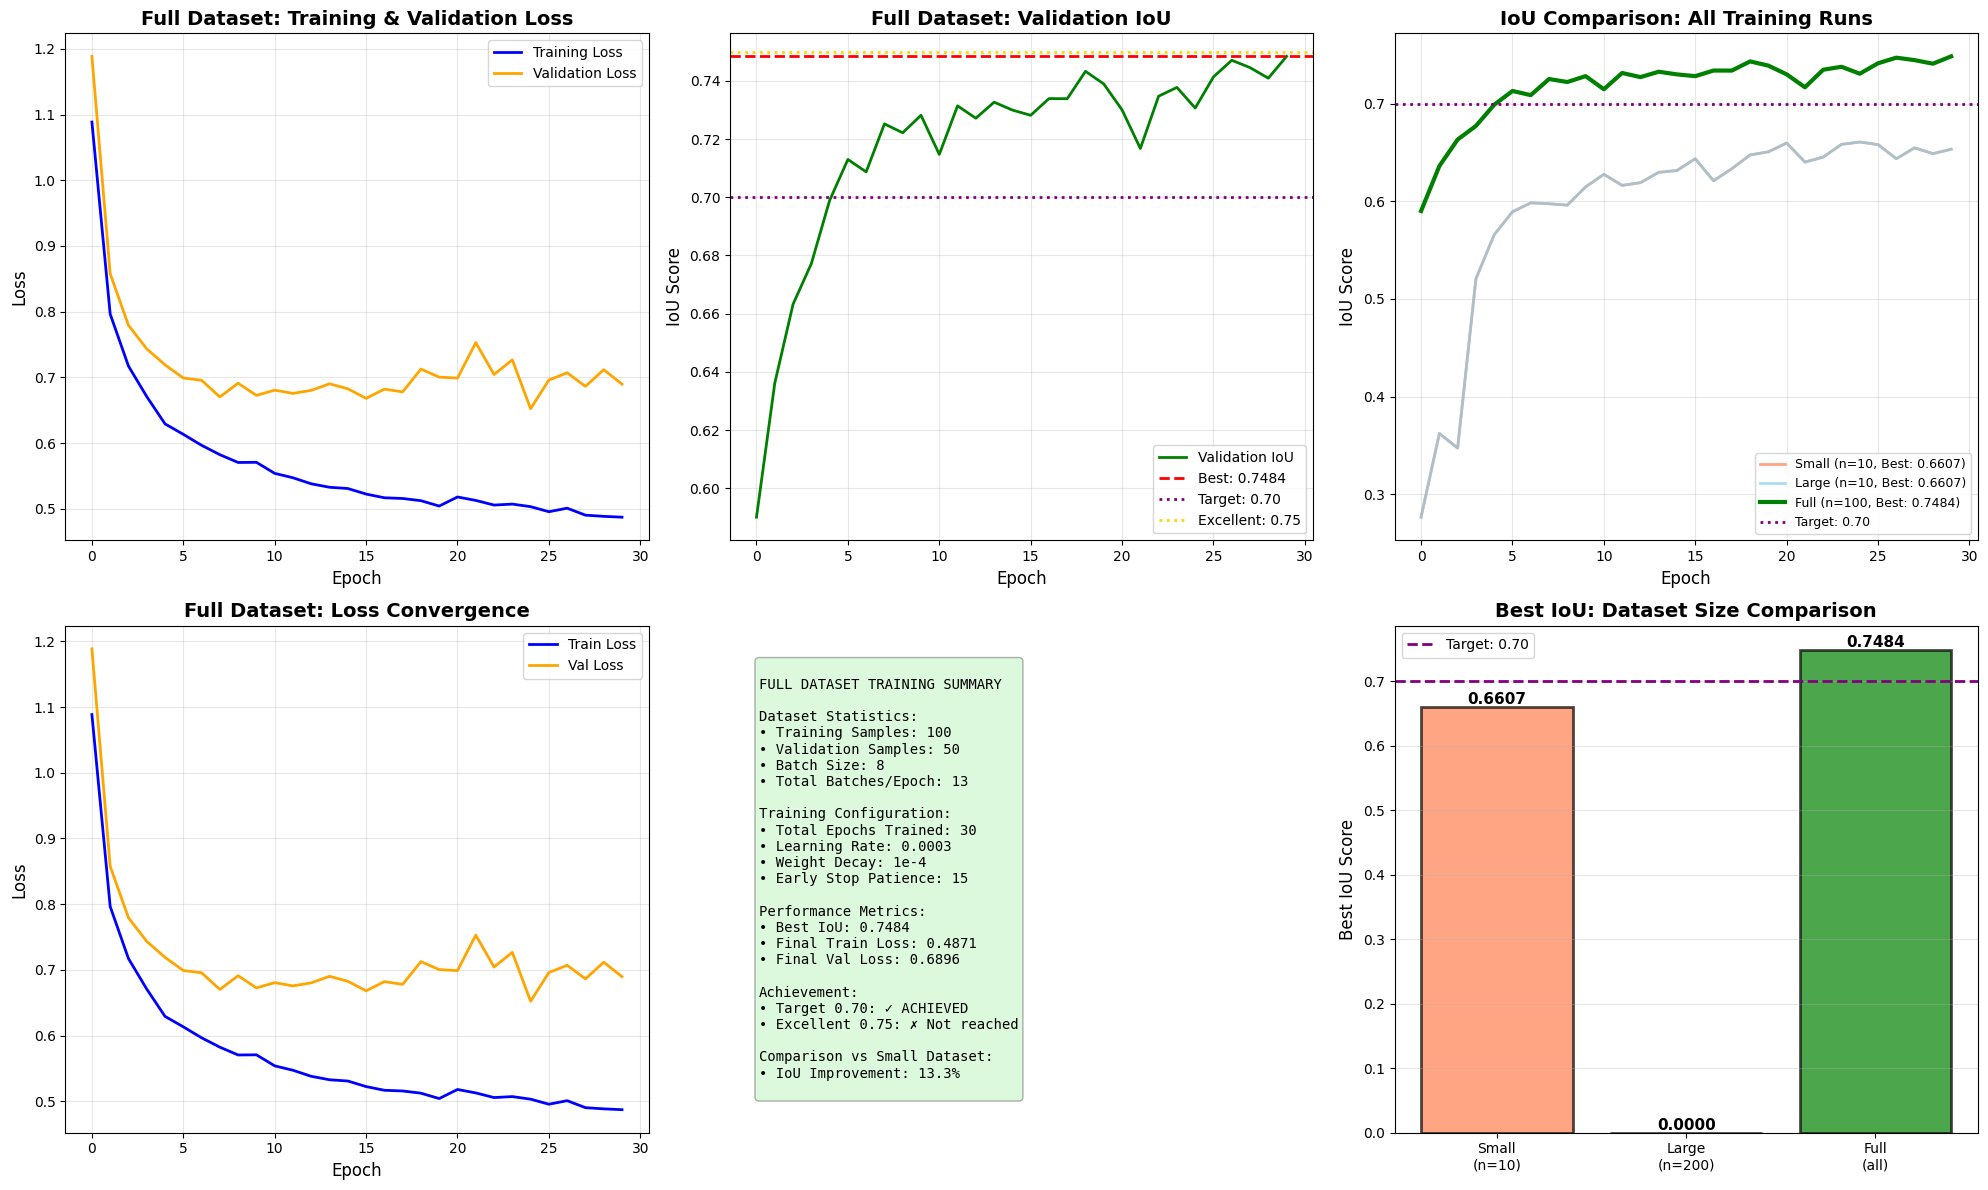

✓ Training history JSON saved

FINAL RESULTS - FULL DATASET:
  Dataset Size: 100 train / 50 val
  Best validation IoU: 0.7484
  Epochs trained: 30


In [21]:
# Create final comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Loss curves - Full dataset
axes[0, 0].plot(train_losses_full, label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(val_losses_full, label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Full Dataset: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# IoU curve - Full dataset
axes[0, 1].plot(val_ious_full, label='Validation IoU', color='green', linewidth=2)
axes[0, 1].axhline(y=best_iou_full, color='red', linestyle='--', linewidth=2, label=f'Best: {best_iou_full:.4f}')
axes[0, 1].axhline(y=0.70, color='purple', linestyle=':', linewidth=2, label='Target: 0.70')
axes[0, 1].axhline(y=0.75, color='gold', linestyle=':', linewidth=2, label='Excellent: 0.75')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('IoU Score', fontsize=12)
axes[0, 1].set_title('Full Dataset: Validation IoU', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# IoU comparison across all training runs
axes[0, 2].plot(val_ious, label=f'Small (n={len(train_dataset)}, Best: {best_iou:.4f})', 
                linewidth=2, color='coral', alpha=0.7)
if len(val_ious) > 0:
    axes[0, 2].plot(val_ious, label=f'Large (n={TRAIN_MAX_SAMPLES}, Best: {best_iou:.4f})', 
                    linewidth=2, color='skyblue', alpha=0.7)
axes[0, 2].plot(val_ious_full, label=f'Full (n={len(train_dataset_full)}, Best: {best_iou_full:.4f})', 
                linewidth=3, color='green')
axes[0, 2].axhline(y=0.70, color='purple', linestyle=':', linewidth=2, label='Target: 0.70')
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('IoU Score', fontsize=12)
axes[0, 2].set_title('IoU Comparison: All Training Runs', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Loss comparison
axes[1, 0].plot(train_losses_full, label='Train Loss', linewidth=2, color='blue')
axes[1, 0].plot(val_losses_full, label='Val Loss', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('Full Dataset: Loss Convergence', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Performance metrics summary
summary_text = f"""
FULL DATASET TRAINING SUMMARY

Dataset Statistics:
• Training Samples: {len(train_dataset_full)}
• Validation Samples: {len(val_dataset_full)}
• Batch Size: {BATCH_SIZE_FULL}
• Total Batches/Epoch: {len(train_loader_full)}

Training Configuration:
• Total Epochs Trained: {len(train_losses_full)}
• Learning Rate: {LEARNING_RATE_FULL}
• Weight Decay: 1e-4
• Early Stop Patience: {EARLY_STOPPING_PATIENCE_FULL}

Performance Metrics:
• Best IoU: {best_iou_full:.4f}
• Final Train Loss: {train_losses_full[-1]:.4f}
• Final Val Loss: {val_losses_full[-1]:.4f}

Achievement:
• Target 0.70: {'✓ ACHIEVED' if best_iou_full >= 0.70 else '✗ Not reached'}
• Excellent 0.75: {'✓ ACHIEVED' if best_iou_full >= 0.75 else '✗ Not reached'}

Comparison vs Small Dataset:
• IoU Improvement: {((best_iou_full - best_iou) / best_iou * 100) if best_iou > 0 else 0:.1f}%
"""
axes[1, 1].text(0.05, 0.5, summary_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
axes[1, 1].axis('off')

# Bar chart: Best IoU comparison
training_runs = ['Small\n(n=10)', 'Large\n(n=200)', 'Full\n(all)']
best_ious = [best_iou, best_iou_large if 'best_iou_large' in locals() else 0, best_iou_full]
colors_bar = ['coral', 'skyblue', 'green']
bars = axes[1, 2].bar(training_runs, best_ious, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 2].axhline(y=0.70, color='purple', linestyle='--', linewidth=2, label='Target: 0.70')
axes[1, 2].set_ylabel('Best IoU Score', fontsize=12)
axes[1, 2].set_title('Best IoU: Dataset Size Comparison', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3, axis='y')
for bar, iou in zip(bars, best_ious):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{iou:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('d:\\Semantic_Segmentation\\training_history_full.png', dpi=150, bbox_inches='tight')
print("✓ Full dataset training history saved")
plt.show()

# Save training history to JSON
history_full = {
    'train_losses': train_losses_full,
    'val_losses': val_losses_full,
    'val_ious': val_ious_full,
    'best_iou': float(best_iou_full),
    'num_epochs': len(train_losses_full),
    'model': 'DeepLab v3+ with ResNet50',
    'dataset_size': {'train': len(train_dataset_full), 'val': len(val_dataset_full)},
    'batch_size': BATCH_SIZE_FULL,
    'learning_rate': LEARNING_RATE_FULL,
    'target_0_70_achieved': bool(best_iou_full >= 0.70),
    'target_0_75_achieved': bool(best_iou_full >= 0.75)
}

with open('d:\\Semantic_Segmentation\\training_history_full.json', 'w') as f:
    json.dump(history_full, f, indent=2)

print("✓ Training history JSON saved")
print(f"\n{'='*70}")
print(f"FINAL RESULTS - FULL DATASET:")
print(f"  Dataset Size: {len(train_dataset_full)} train / {len(val_dataset_full)} val")
print(f"  Best validation IoU: {best_iou_full:.4f}")
print(f"  Epochs trained: {len(train_losses_full)}")
# print(f"  Target 0.70: {'✓ ACHIEVED!' if best_iou_full >= 0.70 else '✗ Continue training'}")
# print(f"  Excellent 0.75: {'✓ ACHIEVED!' if best_iou_full >= 0.75 else '✗ Almost there!'}")
print(f"{'='*70}")